# Imports

In [2]:
_ = !pip install hmmlearn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from hmmlearn.hmm import GaussianHMM

from IPython.display import display
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Loading Data

In [5]:
# Collected from OpusData free academic extract samples

# Function to standardize column names
def clean_cols(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(' ', '_')
        .str.replace('-', '_')
        .str.lower()
    )
    return df

# Core movie summaries
movie_basic = clean_cols(pd.read_csv('./MovieData.csv'))
movie_summary = clean_cols(pd.read_csv('./movie_summary.csv'))

# Box office
daily_boxoffice = clean_cols(pd.read_csv('./daily_boxoffice.csv'))
weekly_boxoffice = clean_cols(pd.read_csv('./weekly_boxoffice.csv'))
weekend_boxoffice = clean_cols(pd.read_csv('./weekend_boxoffice.csv'))
weekend_international = clean_cols(pd.read_csv('./weekend_international.csv'))
international_financials = clean_cols(
    pd.read_csv('./international_financials.csv')
)

# Video / home entertainment
movie_video_summary = clean_cols(pd.read_csv('./movie_video_summary.csv'))
movie_video_releases = clean_cols(pd.read_csv('./movie_video_releases.csv'))
movie_weekly_vod = clean_cols(pd.read_csv('./movie_weekly_vod.csv'))
movie_weekly_dvd = clean_cols(pd.read_csv('./movie_weekly_dvd.csv'))
movie_weekly_bluray = clean_cols(pd.read_csv('./movie_weekly_bluray.csv'))
movie_weekly_physical_disc_rental = clean_cols(
    pd.read_csv('./movie_weekly_physical_disc_rental.csv')
)

# Credits / people
acting_credits = clean_cols(pd.read_csv('./acting_credits.csv'))
technical_credits = clean_cols(pd.read_csv('./technical_credits.csv'))
people = clean_cols(pd.read_csv('./people.csv'))

# Production context
production_companies = clean_cols(pd.read_csv('./production_companies.csv'))
production_countries = clean_cols(pd.read_csv('./production_countries.csv'))
movie_languages = clean_cols(pd.read_csv('./movie_languages.csv'))
movie_keywords = clean_cols(pd.read_csv('./movie_keywords.csv'))
movie_franchises = clean_cols(pd.read_csv('./movie_franchises.csv'))
movie_ratings = clean_cols(pd.read_csv('./movie_ratings.csv'))
movie_releases = clean_cols(pd.read_csv('./movie_releases.csv'))

# Website identifiers
movie_identifiers = clean_cols(pd.read_csv('./movie_identifiers.csv'))

# Data Pre-Processing

In [6]:
# Master table for movies using movie_odid
movie_master = movie_basic.copy()

# Add in rows from 50 blockbuster sample
blockbuster_info = movie_summary[
    ['display_name',
    'production_year',
    'movie_odid',
    'production_budget',
    'domestic_box_office',
    'international_box_office',
    'creative_type',
    'source',
    'production_method',
    'genre',
    'sequel',
    'running_time',]
]
blockbuster_info = blockbuster_info.rename(
    columns={'display_name': 'movie_name'}
)
blockbuster_info = blockbuster_info.merge(
    movie_ratings[['movie_odid', 'rating']], on='movie_odid', how='left'
)
movie_master = pd.concat([movie_master, blockbuster_info], ignore_index=True)

# Ensure that numbers are converted to numerics
for col in [
    'production_year',
    'production_budget',
    'domestic_box_office',
    'international_box_office',
    'sequel',
    'running_time',
]:
    movie_master[col] = pd.to_numeric(movie_master[col], errors='coerce')

# Drop films with missing/zero budget
movie_master = movie_master[movie_master['production_budget'] > 0]

# Calculate the worldwide box office as the sum of domestic and international
movie_master['worldwide_box_office'] = (
    movie_master['domestic_box_office'].fillna(0)
    + movie_master['international_box_office'].fillna(0)
)

# Calculate the log of box office and budget
for col in [
    'domestic_box_office',
    'international_box_office',
    'worldwide_box_office',
    'production_budget',
]:
    movie_master[f'log_{col}'] = np.log1p(movie_master[col])

# Calculate return on investment based on box office and budget
for loc in {'domestic', 'international', 'worldwide'}:
    movie_master[f'roi_{loc}'] = (
        movie_master[f'{loc}_box_office'] / movie_master['production_budget']
    )

# Success indicator: did worldwide box office at least double production budget?
movie_master['success_indicator'] = (
    (movie_master['worldwide_box_office'] >= (
        2 * movie_master['production_budget'])
    )
)

# Sort master data by ID
movie_master = movie_master.sort_values('movie_odid')

In [7]:
# Weekly box office data for 50 blockbuster sample
weekly_data = weekly_boxoffice.copy()

# Ensure that dates are converted to datetimes
weekly_data['chart_date'] = pd.to_datetime(
    weekly_data['chart_date'], errors='coerce'
)

# Ensure that numbers are converted to numerics
for col in [
    'revenue',
    'revenue_estimated',
    'tickets',
    'theaters',
    'total_revenue',
    'total_tickets',
    'days_in_release',
]:
    weekly_data[col] = pd.to_numeric(weekly_data[col], errors='coerce')

# Sort weekly data and create week_index for number of weeks in box office
weekly_data = weekly_data.sort_values(
    ['movie_odid', 'days_in_release', 'chart_date']
)
weekly_data['week_index'] = (
    weekly_data.groupby('movie_odid').cumcount() + 1
)

# Calculate the log of revenue
weekly_data['log_revenue'] = np.log1p(weekly_data['revenue'])

# Calculate revenue per theater
weekly_data['rev_per_theater'] = (
    weekly_data['revenue'] / weekly_data['theaters']
)

# Calculate change in revenue (%) and change in number of theaters (per week)
weekly_data['rev_change_pct'] = (
    weekly_data.groupby('movie_odid')['revenue'].pct_change()
)
weekly_data['num_theater_change'] = (
    weekly_data.groupby('movie_odid')['theaters'].diff()
)

# Movie IDs
movie_ids = weekly_data['movie_odid'].unique()

# HMM Sample (using 50 blockbuster movies)

In [8]:
# Subset of master list for films that have weekly box office data
movie_master_50 = movie_master[movie_master['movie_odid'].isin(movie_ids)]

# Total number of weeks in box office (per movie)
weeks_per_movie = (
    weekly_data.groupby('movie_odid')['week_index'].max()
    .rename('weeks_in_release')
)
movie_master_50 = movie_master_50.merge(
    weeks_per_movie, on='movie_odid', how='left'
)

# Full sample of weekly data to use for HMM
weekly_hmm = weekly_data.merge(
    movie_master_50,
    on='movie_odid',
    how='inner',
)

# Ensure that HMM sample is cleaned
weekly_hmm = weekly_hmm[
    weekly_hmm['revenue'].notna()
    & weekly_hmm['theaters'].notna()
    & (weekly_hmm['theaters'] > 0)
]

# Data Summary Statistics

In [9]:
# Print descriptive statistics of all 2,276 movies
summary_movie_master = movie_master[
    ['production_budget',
     'domestic_box_office',
     'international_box_office',
     'worldwide_box_office',
     'roi_worldwide']
].describe(percentiles=[0.25, 0.5, 0.75])

# Print descriptive statistics of original metadata by excluding 50 blockbusters
summary_movie_basic = movie_master[
    movie_master['movie_odid'].isin(movie_basic['movie_odid'])
    ][
    ['production_budget',
     'domestic_box_office',
     'international_box_office',
     'worldwide_box_office',
     'roi_worldwide']
].describe(percentiles=[0.25, 0.5, 0.75])

# Descriptive statistics about 50 blockbuster movies
summary_movie_50 = movie_master_50[
    ['production_budget',
     'domestic_box_office',
     'international_box_office',
     'worldwide_box_office',
     'roi_worldwide',
     'weeks_in_release',]
].describe(percentiles=[0.25, 0.5, 0.75])
genre_counts_50 = movie_master_50['genre'].value_counts(dropna=False)
sequel_counts_50 = movie_master_50['sequel'].value_counts(dropna=False)
rating_counts_50 = movie_master_50['rating'].value_counts(dropna=False)

# Number of weeks in theaters
weeks_summary = weeks_per_movie.describe()

# Weekly revenue
revenue_summary = weekly_hmm['revenue'].describe(percentiles=[0.25, 0.5, 0.75])

# Theaters per week
theaters_summary = weekly_hmm['theaters'].describe(percentiles=[0.25, 0.5, 0.75])

# Print summary statistics
print('Statistics for movie_master:')
display(summary_movie_master)
print('Statistics for movie_basic:')
display(summary_movie_basic)
print('Statistics for 50 blockbuster movies:')
display(summary_movie_50)
print('\nStatistics for number of weeks in theaters:')
display(weeks_summary)
print('\nStatistics for genre:')
display(genre_counts_50)
print('\nStatistics for sequel status:')
display(sequel_counts_50)
print('\nStatistics for ratings:')
display(rating_counts_50)
print('\nStatistics for weekly revenue:')
display(revenue_summary)
print('\nStatistics for theaters per week:')
display(theaters_summary)

Statistics for movie_master:


,production_budget,domestic_box_office,international_box_office,worldwide_box_office,roi_worldwide
count,"2,276.00","2,276.00","2,276.00","2,276.00","2,276.00"
mean,"46,039,226.75","60,091,453.38","90,521,282.60","150,612,735.98",4.00
std,"60,099,937.37","103,685,670.31","177,046,162.90","271,009,025.60",11.65
min,"9,000.00",0.00,0.00,17.00,0.00
25%,"7,500,000.00","1,746,632.25","1,998,604.25","7,309,969.25",0.71
50%,"20,755,827.00","20,536,095.00","19,141,459.00","42,429,088.00",2.06
75%,"60,000,000.00","65,212,928.75","86,308,120.00","155,573,965.50",4.21
max,"533,200,000.00","936,662,225.00","1,977,903,876.00","2,717,503,922.00",429.64


Statistics for movie_basic:


,production_budget,domestic_box_office,international_box_office,worldwide_box_office,roi_worldwide
count,"2,226.00","2,226.00","2,226.00","2,226.00","2,226.00"
mean,"44,445,184.23","53,786,828.53","82,644,641.53","136,431,470.06",3.81
std,"58,879,158.24","95,047,643.11","167,541,732.36","253,212,293.13",11.51
min,"9,000.00",0.00,0.00,17.00,0.00
25%,"7,000,000.00","1,518,675.75","1,900,765.50","7,007,252.00",0.68
50%,"20,000,000.00","19,414,060.00","17,552,748.50","40,700,036.00",1.97
75%,"55,000,000.00","60,697,323.25","77,198,752.00","138,977,671.00",4.06
max,"533,200,000.00","936,662,225.00","1,977,903,876.00","2,717,503,922.00",429.64


Statistics for 50 blockbuster movies:


,production_budget,domestic_box_office,international_box_office,worldwide_box_office,roi_worldwide,weeks_in_release
count,50.00,50.00,50.00,50.00,50.00,50.00
mean,"117,006,000.00","340,773,351.68","441,189,343.14","781,962,694.82",12.05,29.46
std,"70,898,718.82","82,005,062.70","228,923,033.14","287,581,863.92",14.66,14.58
min,"10,500,000.00","252,651,617.00","85,096,578.00","347,522,208.00",2.76,7.00
25%,"60,750,000.00","290,398,924.75","281,350,720.50","594,727,921.75",4.68,21.25
50%,"115,000,000.00","316,783,061.00","431,618,222.00","791,261,770.00",7.54,23.00
75%,"157,750,000.00","380,464,671.75","563,041,071.25","925,296,817.50",12.26,34.50
max,"300,000,000.00","674,460,013.00","1,548,588,773.00","2,223,048,786.00",75.93,71.00



Statistics for number of weeks in theaters:


,weeks_in_release
count,50.00
mean,29.46
std,14.58
min,7.00
25%,21.25
50%,23.00
75%,34.50
max,71.00



Statistics for genre:


,count
genre,
Adventure,36
Action,5
Drama,3
Comedy,3
Thriller/Suspense,2
Horror,1



Statistics for sequel status:


,count
sequel,
0.00,27
1.00,23



Statistics for ratings:


,count
rating,
PG-13,26
PG,18
R,3
G,3



Statistics for weekly revenue:


,revenue
count,"1,473.00"
mean,"11,064,708.65"
std,"24,013,149.86"
min,509.00
25%,"360,681.00"
50%,"1,585,406.00"
75%,"9,542,156.00"
max,"238,615,211.00"



Statistics for theaters per week:


,theaters
count,"1,473.00"
mean,"1,281.25"
std,"1,237.51"
min,1.00
25%,267.00
50%,769.00
75%,"2,173.00"
max,"4,393.00"


# Fitting HMM to Sample (using HMMLearn)

In [10]:
# Weekly dataframe for HMM
hmm_df = weekly_hmm.copy()

# Sort by movie and week
hmm_df = hmm_df.sort_values(['movie_odid', 'week_index'])

# Build observation matrix X and sequence lengths using log-revenue
X = hmm_df[['log_revenue']].to_numpy()
seq_lengths = (
    hmm_df.groupby('movie_odid')['log_revenue'].size().tolist()
)

# Fit Gaussian HMM with 3 states
K = 3
hmm_model = GaussianHMM(
    n_components=K,
    covariance_type='full',
    n_iter=200,
    random_state=0,
)
hmm_model.fit(X, seq_lengths)

# Determine most-likely hidden state for each week of each movie
hmm_states = hmm_model.predict(X, seq_lengths)
hmm_df['state'] = hmm_states

# Number of weeks in each state per movie
movie_state_share = (
    hmm_df.groupby(['movie_odid', 'state'])
    .size()
    .unstack(fill_value=0)
)

# Convert number of weeks in each state to percentage share
movie_state_share = movie_state_share.div(
    movie_state_share.sum(axis=1), axis=0
)
movie_state_share = movie_state_share.add_prefix('state_').reset_index()

# Combine state shares with movie master subset list
movie_master_50_hmm = movie_master_50.merge(
    movie_state_share,
    on='movie_odid',
    how='left',
)

# Results

In [11]:
# Sort states by mean log-revenue in ascending order
state_means = (
    hmm_df.groupby('state')['log_revenue']
    .mean()
    .sort_values()
)

print('States by log-revenue mean (ascending):')
display(state_means)

States by log-revenue mean (ascending):


,log_revenue
state,
0,12.23
2,14.64
1,16.96


In [12]:
# Determine correlation of worldwide ROI with budget, weeks, and states
corr_matrix = movie_master_50_hmm[
    ['roi_worldwide',
    'production_budget',
    'weeks_in_release',
    'state_0',
    'state_1',
    'state_2',]
].corr()
print('Correlation of worldwide ROI:')
display(corr_matrix['roi_worldwide'])

Correlation of worldwide ROI:


,roi_worldwide
roi_worldwide,1.00
production_budget,-0.62
weeks_in_release,0.33
state_0,-0.51
state_1,0.11
state_2,0.56


In [13]:
# Print mean state shares for successful vs. unsuccessful films
success_state_means = movie_master_50_hmm.groupby('success_indicator')[
    ['state_0', 'state_1', 'state_2']
].mean()
print('Mean state shares based on whether film is successful (True/False):')
display(success_state_means)

Mean state shares based on whether film is successful (True/False):


,state_0,state_1,state_2
success_indicator,,,
True,0.40,0.32,0.27


In [14]:
# Create ROI-based groups based on median ROI
median_roi = movie_master_50_hmm['roi_worldwide'].median()

# High-ROI group contains movies with top 50% of ROI
# Low-ROI group contains movies with bottom 50% of ROI
movie_master_50_hmm['roi_group'] = np.where(
    movie_master_50_hmm['roi_worldwide'] >= median_roi,
    'high_roi',
    'low_roi',
)

roi_state_means = movie_master_50_hmm.groupby('roi_group')[
    ['state_0', 'state_1', 'state_2']
].mean()

print('Median ROI:', median_roi)
print('\nMean state shares by ROI group:')
display(roi_state_means)

Median ROI: 7.541632157217391

Mean state shares by ROI group:


,state_0,state_1,state_2
roi_group,,,
high_roi,0.35,0.32,0.34
low_roi,0.46,0.33,0.21


In [15]:
# Summary statistics by ROI group: budgets, weeks, and state shares
summary_by_roi = movie_master_50_hmm.groupby('roi_group')[
    ['roi_worldwide', 'production_budget', 'weeks_in_release',
     'state_0', 'state_1', 'state_2']
].agg(['mean', 'median'])

print('Summary statistics by ROI group:')
display(summary_by_roi)

Summary statistics by ROI group:


roi_worldwide        production_budget                weeks_in_release        state_0        state_1         \
                   mean median              mean         median             mean median    mean median    mean median   
roi_group                                                                                                               
high_roi          19.46  12.36     64,252,000.00  60,000,000.00            36.04  29.00    0.35   0.42    0.32   0.30   
low_roi            4.63   4.67    169,760,000.00 151,000,000.00            22.88  22.00    0.46   0.50    0.33   0.32   

          state_2         
             mean median  
roi_group                 
high_roi     0.34   0.31  
low_roi      0.21   0.18

In [16]:
# Mean state shares by genre
genre_state = (
    movie_master_50_hmm.groupby('genre')[['state_0', 'state_1', 'state_2']]
    .agg(['mean', 'count'])
)

print('Mean state share by genre:')
display(genre_state)

Mean state share by genre:


state_0       state_1       state_2      
                     mean count    mean count    mean count
genre                                                      
Action               0.38     5    0.31     5    0.31     5
Adventure            0.43    36    0.31    36    0.26    36
Comedy               0.30     3    0.38     3    0.31     3
Drama                0.28     3    0.33     3    0.39     3
Horror               0.14     1    0.57     1    0.29     1
Thriller/Suspense    0.44     2    0.31     2    0.25     2

In [17]:
# Mean state shares for sequel vs. no sequel
movie_master_50_hmm['is_sequel'] = (
    movie_master_50_hmm['sequel'] > 0
).astype(int)

sequel_state = movie_master_50_hmm.groupby('is_sequel')[
    ['state_0', 'state_1', 'state_2']
].mean()

print('Mean state shares for sequel vs. no sequel:')
display(sequel_state)

Mean state shares for sequel vs. no sequel:


,state_0,state_1,state_2
is_sequel,,,
0,0.37,0.32,0.31
1,0.44,0.33,0.23


In [18]:
# Mean state shares by MPAA rating
rating_state = movie_master_50_hmm.groupby('rating')[
    ['state_0', 'state_1', 'state_2']
].mean()

print('Mean state shares by MPAA rating:')
display(rating_state)

Mean state shares by MPAA rating:


,state_0,state_1,state_2
rating,,,
G,0.57,0.21,0.22
PG,0.35,0.36,0.29
PG-13,0.41,0.31,0.27
R,0.50,0.29,0.21


In [19]:
# Linear regression for worldwide ROI vs. budget and states 0 and 2

reg1_df = movie_master_50_hmm[
    ['roi_worldwide', 'log_production_budget', 'state_0', 'state_2']
]

X1 = reg1_df[['log_production_budget', 'state_0', 'state_2']].to_numpy()
y1 = reg1_df['roi_worldwide'].to_numpy()

reg1 = LinearRegression()
reg1.fit(X1, y1)

coef_names1 = ['log_production_budget', 'state_0 (low)', 'state_2 (mid)']
print('Linear regression: roi_worldwide ~ log_budget + state_0 + state_2')
print(f'\nIntercept: {reg1.intercept_:.3f}')
for name, coef in zip(coef_names1, reg1.coef_):
    print(f'{name}: {coef:.3f}')

Linear regression: roi_worldwide ~ log_budget + state_0 + state_2

Intercept: 234.931
log_production_budget: -12.606
state_0 (low): 2.997
state_2 (mid): 24.426


In [20]:
# Linear regression for worldwide box office vs. budget and states 0 and 2

reg2_df = movie_master_50_hmm[
    ['log_worldwide_box_office', 'log_production_budget', 'state_0', 'state_2']
]

X2 = reg2_df[['log_production_budget', 'state_0', 'state_2']].to_numpy()
y2 = reg2_df['log_worldwide_box_office'].to_numpy()

reg2 = LinearRegression()
reg2.fit(X2, y2)

coef_names2 = ['log_production_budget', 'state_0 (low)', 'state_2 (mid)']
print('Linear regression: log_worldwide_box_office ~ log_budget + state_0 + state_2')
print(f'\nIntercept: {reg2.intercept_:.3f}')
for name, coef in zip(coef_names2, reg2.coef_):
    print(f'{name}: {coef:.3f}')

Linear regression: log_worldwide_box_office ~ log_budget + state_0 + state_2

Intercept: 15.680
log_production_budget: 0.225
state_0 (low): 0.512
state_2 (mid): 1.498


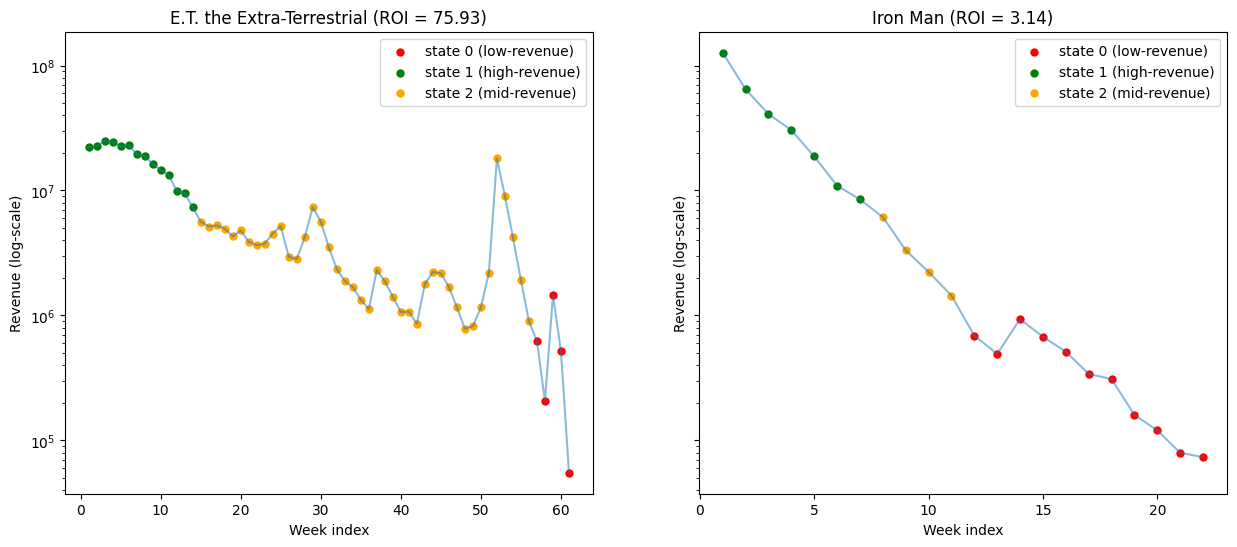

In [60]:
# Plot for state shares based on revenue vs. week

ordered_states = state_means.index.tolist()

STATE_COLOR = {
    ordered_states[0]: "red",
    ordered_states[1]: "orange",
    ordered_states[2]: "green",
}

STATE_LABEL = {
    ordered_states[0]: "state 0 (low-revenue)",
    ordered_states[1]: "state 2 (mid-revenue)",
    ordered_states[2]: "state 1 (high-revenue)",
}

def plot_movie_trajectory(movie_id, ax, df=hmm_df, meta_df=movie_master_50_hmm,
                          logy=False):
    example = df[df['movie_odid'] == movie_id]
    example = example.sort_values('week_index')

    # Look up ROI and title of movie
    row = meta_df[meta_df['movie_odid'] == movie_id]
    roi_val = row['roi_worldwide'].iloc[0]
    movie_name = row['movie_name'].iloc[0]

    # Plot trajectory line
    ax.plot(example['week_index'], example['revenue'], alpha=0.5)

    # Scatter plot of revenue per week
    for s in sorted(example['state'].unique()):
        m = (example['state'] == s)
        ax.scatter(
            example.loc[m, 'week_index'],
            example.loc[m, 'revenue'],
            color=STATE_COLOR.get(s, 'black'),
            s=25,
            label=STATE_LABEL.get(s, f'State {s}'),
        )

    # Check if y-scale is log
    if logy:
        ax.set_yscale('log')

    ax.set_title(f'{movie_name} (ROI = {roi_val:.2f})')
    ax.set_xlabel('Week index')
    ax.set_ylabel(f'Revenue{' (log-scale)' if logy else ''}')
    ax.legend()

# High-ROI vs low-ROI example trajectories
high_id = movie_master_50_hmm.sort_values(
    'roi_worldwide', ascending=False
)['movie_odid'].iloc[0]
low_id  = movie_master_50_hmm.sort_values(
    'roi_worldwide', ascending=True
)['movie_odid'].iloc[2]

# Plot graphs side by side to show comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
plot_movie_trajectory(high_id, ax=axes[0], logy=True)
plot_movie_trajectory(low_id,  ax=axes[1], logy=True)
plt.show()